---
title: SpatioTemporal Field - T2M - Stationary - EDA
subject: AEMET T2M
short_title: 2a - Model
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CSIC
      - UCM
      - IGEO
    orcid: 0000-0002-6739-0053
    email: juanjohn@ucm.es
license: CC-BY-4.0
keywords: notation
---

In [18]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "" # first gpu
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'FALSE'

import jax
jax.config.update('jax_platform_name', 'cpu')

import numpyro
import multiprocessing

num_devices = multiprocessing.cpu_count()
numpyro.set_platform("cpu")
# numpyro.set_host_device_count(4)
# num_chains = 5
numpyro.set_host_device_count(num_devices)

In [19]:
import autoroot
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray

from st_evt.utils import ExperimentPath
from omegaconf import OmegaConf

import jax
import jax.random as jrandom
import jax.numpy as jnp
import pandas as pd

rng_key = jrandom.PRNGKey(123)

from numpyro.infer import Predictive
import arviz as az

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import xarray as xr
import regionmask

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)



# num_devices = 5
# numpyro.set_host_device_count(num_devices)


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [20]:
config_file_name = "/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/config/config.json"
config = OmegaConf.load(config_file_name)

config

{'experiment_name': 'walkthrough/ts_t2m_spain/stationary_iid', 'dataset': 'aemet', 'station_id': 'spain-redfeten', 'variable': 't2m', 'likelihood': 'gevd', 'freq': 'summer', 'dependence': 'temporal', 'parameterization': 'linear', 'config_file_name': 'aemet_spain_stationary.yaml', 'covariate_path': '/home/juanjohn/pool_data/dynev4eo/data/clean/gmst.zarr', 'dataset_path': '/home/juanjohn/pool_data/dynev4eo/data/clean/t2m_stations_spain.zarr', 'exp_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid', 'figures_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/figures/eda', 'data_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/data', 'clean_data_path': '/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/data/clean_data.nc'}

### Data

In [21]:
root_path = Path(config["exp_path"])
clean_data_path = Path(config["clean_data_path"])
covariate_data_path = Path(config["covariate_path"])


exp_file_config = ExperimentPath(root_dir=root_path)
figures_path = exp_file_config.figures_model_dir
data_path = exp_file_config.data_dir

### Statistics summary

In [22]:
# LOAD DATA
with xr.open_dataset(clean_data_path, engine="netcdf4") as f:
    ds_bm = f.load()
ds_bm

# covariate = "gmst"
covariate = "gmst"
variable = "t2m_max"
variable_bm = "t2m_max_bm_year"

# RESAMPLE (to remove NANS)
ds_bm = ds_bm[[variable_bm]].resample(time="1YE").max()

# ADD COVARIATE
ds_gmst = xr.open_dataset(covariate_data_path, engine="zarr").load()
ds_gmst = ds_gmst.interp_like(ds_bm)
ds_bm[covariate] = ds_gmst.GISS_smooth

# REMOVE NANS
ds_bm = ds_bm.dropna(dim="time")

ds_bm

<xarray.Dataset> Size: 68kB
Dimensions:          (time: 60, station_id: 154)
Coordinates:
    alt              (station_id) float32 616B 32.0 118.0 71.0 ... 620.0 10.0
    lat              (station_id) float32 616B 40.96 41.15 41.19 ... 28.49 28.13
    lon              (station_id) float32 616B 0.87 1.108 ... -16.32 -15.42
    red_feten_mask   (station_id) uint8 154B 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
  * station_id       (station_id) <U5 3kB '0002I' '0016B' ... 'C447B' 'C659T'
    station_name     (station_id) <U40 25kB 'vandellòs' ... 'las palmas de g....
  * time             (time) datetime64[ns] 480B 1961-12-31 ... 2020-12-31
Data variables:
    t2m_max_bm_year  (time, station_id) float32 37kB 32.2 33.32 ... 40.31 28.28
    gmst             (time) float64 480B 0.1988 0.1827 0.1587 ... 1.133 1.196

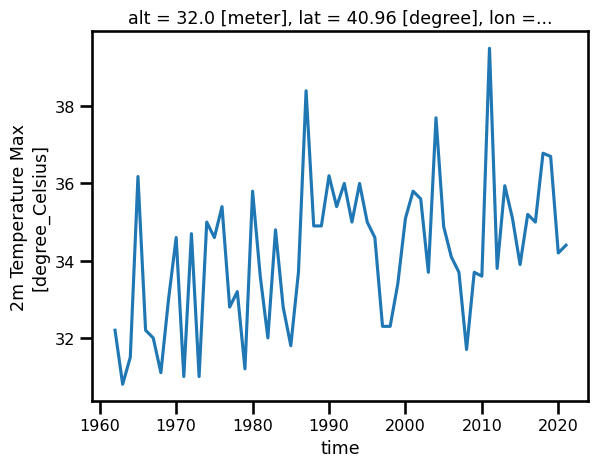

In [6]:
ds_bm[variable_bm].isel(station_id=0).plot()

In [7]:
y = ds_bm[variable_bm].values.squeeze()
t = ds_bm.time.dt.year.values.squeeze()
t_pred = np.linspace(-0.5, 2.0, 50)
num_spatial = y.shape[1]
t.shape, y.shape

((60,), (60, 154))

### Hierarchical Parameterization

In [8]:
# initialize empirical values
empirical_loc = ds_bm[variable_bm].mean().values.squeeze()
empirical_std = ds_bm[variable_bm].std().values.squeeze()

print(f"Loc: {empirical_loc.squeeze():.2f}")
print(f"Scale: {empirical_std.squeeze():.2f}")

empirical_loc_log = np.log(empirical_loc)
empirical_std_log = np.log(empirical_std)

print(f"Loc (log): {empirical_loc_log:.2f}")
print(f"Scale (log): {empirical_std_log:.2f}")

Loc: 36.21
Scale: 4.07
Loc (log): 3.59
Scale (log): 1.40


In [9]:
empirical_loc_init = ds_bm[variable_bm].mean(dim="time").values
empirical_std_init = ds_bm[variable_bm].std(dim="time").values
empirical_loc_log_init = np.log(empirical_std_init)

## Model

In [10]:
import numpyro
import numpyro.distributions as dist
from tensorflow_probability.substrates.jax import distributions as tfd


def model(y=None, num_timesteps: int=1, *args, **kwargs):

    if y is not None:
        num_timesteps = y.shape[0]

    plate_time = numpyro.plate("time", num_timesteps, dim=-2)
    plate_space = numpyro.plate("space", num_spatial, dim=-1)


    # LOCATION PARAMETER
    
    # location_prior = dist.Normal(empirical_loc_init, empirical_std_init)
    # location = numpyro.sample("location", fn=location_prior)

    with plate_space:
        location_prior = dist.Normal(empirical_loc, empirical_std)
        location = numpyro.sample("location", fn=location_prior)
        # SCALE PARAMETER
        scale_prior = dist.LogNormal(1.25, 0.5)
        scale = numpyro.sample("scale", fn=scale_prior)
    
        # SHAPE Parameter
        concentration_prior = dist.TruncatedNormal(-0.3, 0.1, low=-1.0, high=-1e-5)
        concentration = numpyro.sample("concentration", fn=concentration_prior)

    # create likelihood distribution
    with plate_time, plate_space:
        y_dist = tfd.GeneralizedExtremeValue(loc=location, scale=scale, concentration=concentration)
        y = numpyro.sample("obs", y_dist, obs=y)

    return y

In [11]:
with numpyro.handlers.seed(rng_seed=123):
    data = dict(t=t, y=None)
    y_sample = model()



### Prior Predictions

In [12]:
import arviz as az

In [13]:
from numpyro.infer import Predictive

rng_key, rng_key_ = jrandom.split(rng_key)
prior_predictive = Predictive(model, num_samples=1_000)
prior_samples = prior_predictive(rng_key_)

In [14]:
az_ds_prior = az.from_numpyro(
    prior=prior_samples,
    dims={
        "obs": ["time", "station_id"],
        "location": ["station_id"],
        "scale": ["station_id"],
        "concentration": [],
    }
    # pred_dims={"obs": ["time"]}
)

In [15]:
az_ds_prior

Inference data with groups:
	> prior

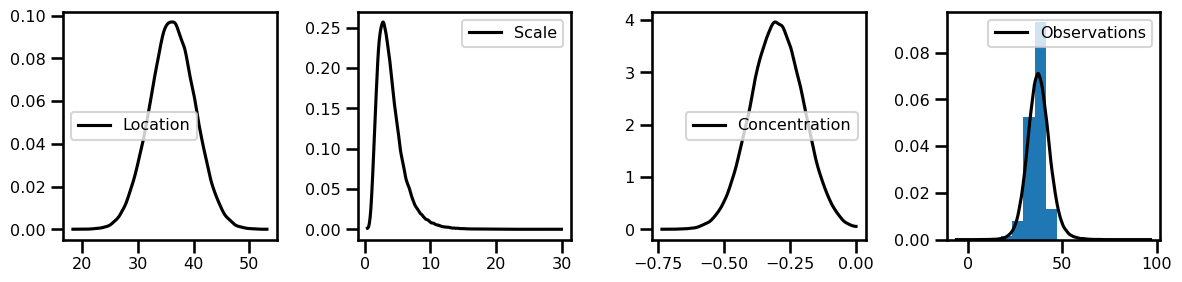

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(12,3))

az.plot_dist(prior_samples["location"], kind="kde", color="black", label="Location", ax=ax[0])
az.plot_dist(prior_samples["scale"], kind="kde", color="black", label="Scale", ax=ax[1])
az.plot_dist(prior_samples["concentration"], kind="kde", color="black", label="Concentration", ax=ax[2])
az.plot_dist(prior_samples["obs"], kind="kde", color="black", label="Observations", ax=ax[3], plot_kwargs=dict(zorder=3))
ax[3].hist(y.ravel(), density=True, bins=5)

fig.savefig(figures_path.joinpath("density_prior.png"))

fig.set(
    dpi=100,
    size_inches=(12,3)
)

plt.tight_layout()
plt.show()

## Inference

In this example, we will use MCMC. We only have 3 parameters so this will be relatively quick.

In [17]:
import optax
# Example usage
init_lr = 1e-6        # Initial learning rate
peak_lr = 1e-3        # Peak learning rate
end_lr = 1e-4         # Final learning rate
warmup_steps = 1_000    # Number of warmup steps
num_steps = 50_000 # Number of steps for the cosine decay
alpha = 0.0           # Minimum learning rate value as a fraction of the initial learning rate
num_samples = 10
schedule = optax.warmup_cosine_decay_schedule(
        init_value=init_lr,
        peak_value=peak_lr,
        end_value=end_lr,
        warmup_steps=warmup_steps,
        decay_steps=num_steps,
    )
# schedule = optax.warmup_cosine_decay_schedule(
#   init_value=0.0,
#   peak_value=1.0,
#   warmup_steps=50,
#   decay_steps=1_000,
#   end_value=0.0,
# )

optimizer = optax.chain(
    optax.adam(learning_rate=schedule),  # Adam optimizer
    # optax.scale_by_schedule(schedule),  # Apply the cosine annealing schedule
    # optax.scale(-1.0),  # Scale the gradients by -1 (gradient descent)
    optax.clip(0.01)
)

In [18]:
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoLaplaceApproximation, AutoDiagonalNormal
from numpyro.infer import init_to_value, init_to_median


# map_guide = AutoDelta(model.model, init_loc_fn=init_to_median())
guide = AutoLaplaceApproximation(model, init_loc_fn=init_to_median(num_samples=100))
# lap_guide = AutoDiagonalNormal(model.model, init_loc_fn=init_to_median())
svi = SVI(model, guide, optimizer, loss=Trace_ELBO(num_samples))

# create key
rng_key_train, rng_key = jrandom.split(rng_key, num=2)

# fit MAP estimate
svi_result = svi.run(rng_key, num_steps=num_steps, y=y)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:13<00:00, 3647.89it/s, init loss: 27632.0996, avg. loss [47501-50000]: 18794.6103]


In [19]:
params = guide.median(svi_result.params)

In [17]:
from numpyro.infer import MCMC, NUTS, SVI, Trace_ELBO, init_to_value, init_to_median

num_samples = 1_000
num_warmup = 10_000

num_chains = 4

sampler = NUTS(
    model,
    # init_strategy=init_to_value(values=params)
    init_strategy=init_to_median(num_samples=100)
)

mcmc = MCMC(
    sampler=sampler,
    num_warmup=num_warmup,
    num_samples=num_samples,
    num_chains=num_chains,
    
)

# create key
rng_key_train, rng_key = jrandom.split(rng_key, num=2)

# RUN MCMC SAMPLER
mcmc.run(rng_key_train, y=y)

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

  0%|          | 0/11000 [00:00<?, ?it/s]

In [23]:
# mcmc.print_summary(exclude_deterministic=False)

## Posterior

In [23]:
posterior_samples = mcmc.get_samples()

### Posterior Predictive

In [24]:
# Get Posterior Samples
predictive = Predictive(
    model=model, posterior_samples=posterior_samples, parallel=True, 
    return_sites=[
        "location", "scale", "concentration", "obs"
    ]
)
# Posterior predictive samples
rng_key, rng_subkey = jrandom.split(rng_key)

posterior_predictive_samples = predictive(rng_subkey, num_timesteps=y.shape[0])

list(posterior_predictive_samples.keys())

['concentration', 'location', 'obs', 'scale']

In [25]:
posterior_predictive_samples["obs"].shape

(4000, 60, 154)

In [26]:
az_ds = az.from_numpyro(
    posterior=mcmc,
    posterior_predictive=posterior_predictive_samples,
    dims={
        "location": ["station_id"],
        "scale": ["station_id"],
        "concentration": ["station_id"],
        "obs": ["time", "station_id"],
    },
    pred_dims={"obs": ["time"]}
)
# correct coordinates
az_ds = az_ds.assign_coords({"time": ds_bm.time})
az_ds = az_ds.assign_coords({"gmst": ds_bm.gmst})
az_ds = az_ds.assign_coords({"station_id": ds_bm.station_id})



az_ds

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

#### MCMC Statistics

In [27]:
stats = az.waic(az_ds)
stats

/home/juanjohn/miniconda/envs/dynev4eo_gpu/lib/python3.11/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 9240 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -18495.28    71.82
p_waic      340.93        -

There has been a warning during the calculation. Please check the results.

In [28]:

az_ds.log_likelihood.attrs["elpd_waic"] = stats.elpd_waic
az_ds.log_likelihood.attrs["se"] = stats.se
az_ds.log_likelihood.attrs["p_waic"] = stats.p_waic

#### Threshold

### Save Data

In [30]:
mcmc_results_path = data_path.joinpath("mcmc_results.nc")
az_ds.to_netcdf(filename=mcmc_results_path)

PosixPath('/home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/data/mcmc_results.nc')

In [31]:
config["mcmc_results_path"] = str(mcmc_results_path)

In [32]:
OmegaConf.save(config, config_file_name)

In [33]:
!cat $config_file_name

experiment_name: walkthrough/ts_t2m_spain/stationary_iid
dataset: aemet
station_id: spain-redfeten
variable: t2m
likelihood: gevd
freq: summer
dependence: temporal
parameterization: linear
config_file_name: aemet_spain_stationary.yaml
covariate_path: /home/juanjohn/pool_data/dynev4eo/data/clean/gmst.zarr
dataset_path: /home/juanjohn/pool_data/dynev4eo/data/clean/t2m_stations_spain.zarr
exp_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid
figures_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/figures/eda
data_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/data
clean_data_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/data/clean_data.nc
mcmc_results_path: /home/juanjohn/pool_data/dynev4eo/experiments/walkthrough/ts_t2m_spain/stationary_iid/data/mcmc_results.nc


/home/juanjohn/miniconda/envs/dynev4eo_gpu/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
